In [15]:
from functions_medscint import *
from PCA_functions import *
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib as mpl

path="/Users/yunuen/PycharmProjects/PC_NPLmeasurements/"

symbol = ['d', '^', 's', 'o', '*']
scintillators = ['bcf10', 'bcf60', 'ej204', 'bcf60-Lee', 'Medscint']
scint_label = ['BCF-10', 'BCF-60', 'EJ-204', 'BCF-60 Lee filter', 'Medscint']
bfields = [0, 0.2, 0.35, 0.5, 1, 1.5]
bfields_label = ['0', '0.2', '0.35', '0.5', '1', '1.5', '0', '-0.2', '-0.35', '-0.5', '-1', '-1.5']
colors = ['tomato', 'deepskyblue', 'mediumseagreen', 'purple', 'grey', 'darkorange', 'plum', 'black', 'tomato']
colors2 = ['salmon', 'lightskyblue', 'lightseagreen', 'mediumorchid',  'black', 'salmon']
data = np.load(path + 'data_npl_measures.npz')

# Read data
# raw calibration data
cal_scint_old = data['cal_scint']
cal_fluo_old = data['cal_fluo']
cal_ckovA_old = data['cal_ckovA']
cal_ckovB_old = data['cal_ckovB']
cal_dose_file = data['cal_dose_file']
# raw measurement data
Data = data['Data']

# Old calibration
Mean_dose_old = data['Mean_dose']
Mean_fluo_old = data['Mean_fluo']
Mean_ckov_old = data['Mean_ckov']
std_dose_old = data['std_dose']
std_fluo_old = data['std_fluo']
std_ckov_old = data['std_ckov']
Mean_spectrum_old = data['Mean_spectrum']


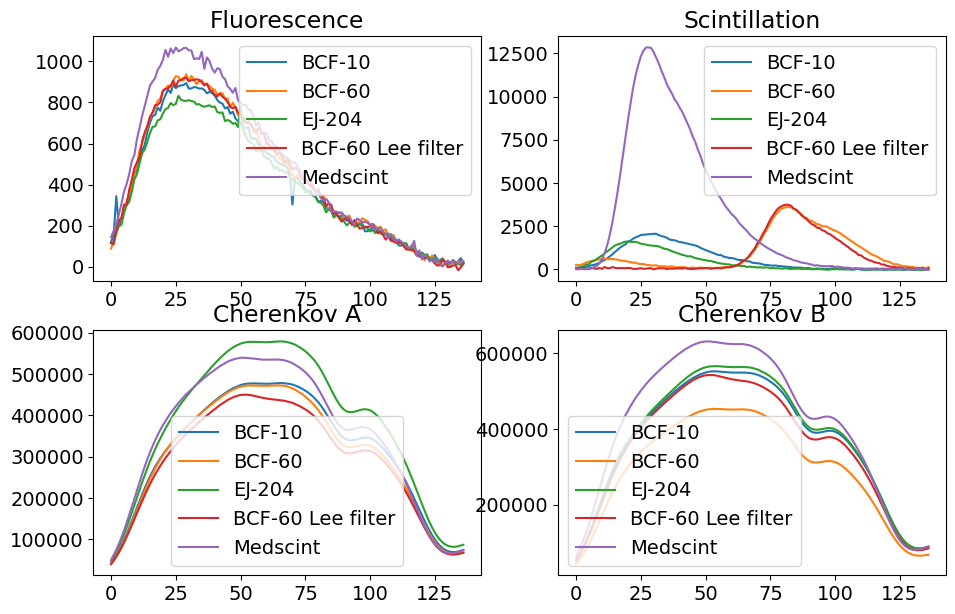

In [16]:
#cal_fluo_old[cal_fluo_old<0]=0
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(11, 7))
for s in range(len(scintillators)):
    plt.subplot(221)
    plt.plot(cal_fluo_old[s], label=scint_label[s])
    plt.title('Fluorescence')
    plt.legend()
    plt.subplot(222)
    plt.plot(cal_scint_old[s], label=scint_label[s])
    plt.title('Scintillation')
    plt.legend()
    plt.subplot(223)
    plt.plot(cal_ckovA_old[s], label=scint_label[s])
    plt.title('Cherenkov A')
    plt.legend()
    plt.subplot(224)
    plt.plot(cal_ckovB_old[s], label=scint_label[s])
    plt.title('Cherenkov B')
    plt.legend()
plt.show()

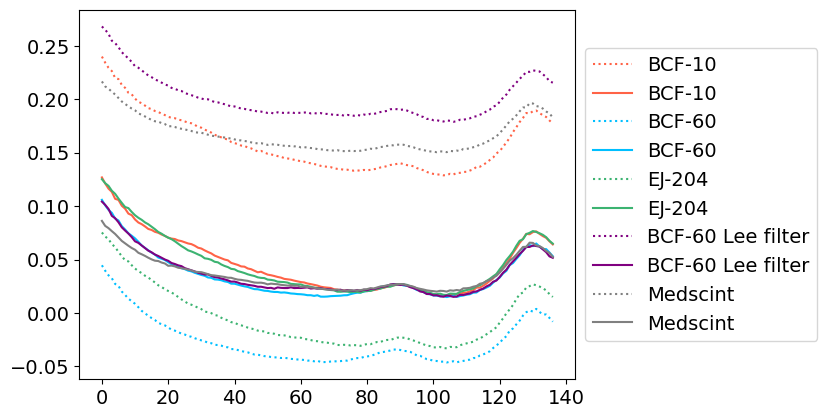

In [17]:
# With the new calibration, Ckov A and B are translated to remove the negative weights. The translation is done to match the local maximum at 0.027
# the exponential attenuation spectrum is given by k_mes
k_mes = np.log(cal_ckovB_old/cal_ckovA_old)
for s in range(len(scintillators)):
    plt.plot(k_mes[s, :], ':', color=colors[s], label=scint_label[s])
    loc_max=max(k_mes[s, 80:100])
    x= 0.027 - loc_max
    k_mes[s, :] = k_mes[s, :] + x
    plt.plot(k_mes[s, :], color=colors[s], label=scint_label[s])
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

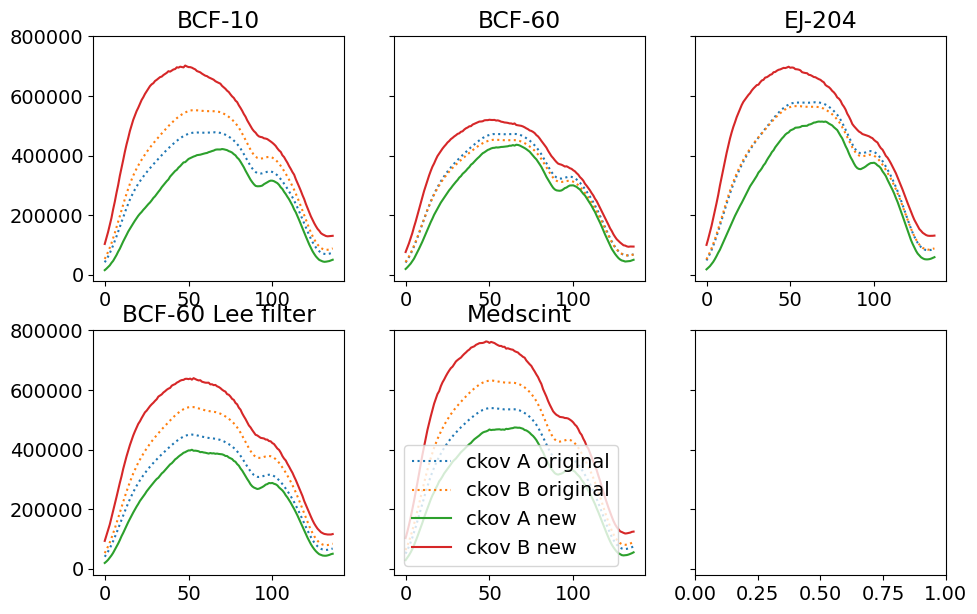

In [18]:
# Translation of the Cherenkov calibration
cal_ckovA_new = np.zeros([5, 137])
cal_ckovB_new = np.zeros([5, 137])
# To move the Cherenkov:

L_A = 5 #[5, 5, 5, 5, 5]
L_B = 7.5 #[7.5, 7.5, 7.5, 7.5, 7.5]

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(11, 7), sharey=True)

for s in range(len(scintillators)):
    cal_ckovA_new[s, :] = cal_ckovA_old[s, :] * (1 - k_mes[s, :] * L_A)
    cal_ckovB_new[s, :] = cal_ckovB_old[s, :] * (1 + k_mes[s, :] * L_B)

    #Figure to see the new Cherenkov
    plt.subplot(2, 3, s+1)
    plt.plot(cal_ckovA_old[s, :], ':', label='ckov A original')
    plt.plot(cal_ckovB_old[s, :], ':', label='ckov B original')
    plt.plot(cal_ckovA_new[s, :],  label='ckov A new')
    plt.plot(cal_ckovB_new[s, :],  label='ckov B new')
    plt.title(scint_label[s])
plt.legend()
plt.show()

In [19]:
def calculate_weigths(cal_scint, cal_fluo, cal_ckovA, cal_ckovB, cal_dose_file, Data, calib_doseval=500):
    Weights = np.zeros([5, 42, 4])
    Mean_dose = np.zeros([5, 12])
    Mean_fluo = np.zeros([5, 12])
    Mean_ckov = np.zeros([5, 12])
    std_dose = np.zeros([5, 12])
    std_fluo = np.zeros([5, 12])
    std_ckov = np.zeros([5, 12])
    std_weight = np.zeros([5, 12, 4])
    Mean_spectrum = np.zeros([5, 12, 137])
    Mean_weight = np.zeros([5, 12, 4])

    for s in range(len(scintillators)):
        # Normalized calibration files
        scint = cal_scint[s]/sum(cal_scint[s])
        fluo = cal_fluo[s]/sum(cal_fluo[s])
        ckovA = cal_ckovA[s]/sum(cal_ckovA[s])
        ckovB = cal_ckovB[s]/sum(cal_ckovB[s])
        dose = cal_dose_file[s]

        # To obtain the abundance
        R = compute_icm([scint, fluo, ckovA, ckovB])
        Ref = generate_weights(R, dose)

        Doses = []
        Fluo = []
        Ckov = []

        for i in range(len(Data[s])):
            Weight = generate_weights(R, Data[s][i])
            Doses.append(Weight[0]  / Ref[0] * calib_doseval)
            Fluo.append(Weight[1] ) #/ Ref[1] * calib_doseval)
            Ckov.append(((Weight[2] + Weight[3])) ) # / (Ref[2] + Ref[3])) * calib_doseval)
            Weights[s, i, :] = Weight

        Moy_doses = []
        Moy_fluo = []
        Moy_ckov = []
        dev_doses = []
        dev_fluo = []
        dev_ckov = []
        Moy_weights = []
        dev_weights = []
        Moy_spectrum = []

        for i in range(int(len(Data[s]) / 3)):

            if i == 0 or i == 7:
                Moy_doses.append(np.mean([Doses[i * 3], Doses[i * 3 + 1], Doses[i * 3 + 2], Doses[i * 3 + 3],
                                          Doses[i * 3 + 4], Doses[i * 3 + 5]]))
                Moy_fluo.append(np.mean([Fluo[i * 3], Fluo[i * 3 + 1], Fluo[i * 3 + 2], Fluo[i * 3 + 3], Fluo[i * 3 + 4],
                                         Fluo[i * 3 + 5]]))
                Moy_ckov.append(np.mean([Ckov[i * 3], Ckov[i * 3 + 1], Ckov[i * 3 + 2], Ckov[i * 3 + 3], Ckov[i * 3 + 4],
                                         Ckov[i * 3 + 5]]))

                dev_doses.append(np.std([Doses[i * 3], Doses[i * 3 + 1], Doses[i * 3 + 2], Doses[i * 3 + 3],
                                         Doses[i * 3 + 4], Doses[i * 3 + 5]]))
                dev_fluo.append(np.std([Fluo[i * 3], Fluo[i * 3 + 1], Fluo[i * 3 + 2], Fluo[i * 3 + 3], Fluo[i * 3 + 4],
                                        Fluo[i * 3 + 5]]))
                dev_ckov.append(np.std([Ckov[i * 3], Ckov[i * 3 + 1], Ckov[i * 3 + 2], Ckov[i * 3 + 3], Ckov[i * 3 + 4],
                                        Ckov[i * 3 + 5]]))
                Moy_spectrum.append(np.mean(Data[s][i * 3:i * 3 + 5], axis=0))
                Moy_weights.append(np.mean(Weights[s][i * 3:i * 3 + 5], axis=0))
                dev_weights.append(np.std(Weights[s][i * 3:i * 3 + 5], axis=0))

            elif i == 1 or i == 8:
                continue
            else:
                Moy_doses.append(np.mean([Doses[i * 3], Doses[i * 3 + 1], Doses[i * 3 + 2]]))
                Moy_fluo.append(np.mean([Fluo[i * 3], Fluo[i * 3 + 1], Fluo[i * 3 + 2]]))
                Moy_ckov.append(np.mean([Ckov[i * 3], Ckov[i * 3 + 1], Ckov[i * 3 + 2]]))
                dev_doses.append(np.std([Doses[i * 3], Doses[i * 3 + 1], Doses[i * 3 + 2]]))
                dev_fluo.append(np.std([Fluo[i * 3], Fluo[i * 3 + 1], Fluo[i * 3 + 2]]))
                dev_ckov.append(np.std([Ckov[i * 3], Ckov[i * 3 + 1], Ckov[i * 3 + 2]]))
                Moy_spectrum.append(np.mean(Data[s][i * 3:i * 3 + 2], axis=0))
                Moy_weights.append(np.mean(Weights[s][i * 3:i * 3 + 2], axis=0))
                dev_weights.append(np.std(Weights[s][i * 3:i * 3 + 2], axis=0))

        Mean_dose[s] = Moy_doses
        Mean_fluo[s] = Moy_fluo
        Mean_ckov[s] = Moy_ckov
        std_dose[s] = dev_doses
        std_fluo[s] = dev_fluo
        std_ckov[s] = dev_ckov

        Mean_spectrum[s] = Moy_spectrum
        Mean_weight[s] = Moy_weights
        std_weight[s] = dev_weights

    return  Mean_dose, Mean_fluo, Mean_ckov,  std_dose, std_fluo, std_ckov, Mean_spectrum, Mean_weight, std_weight



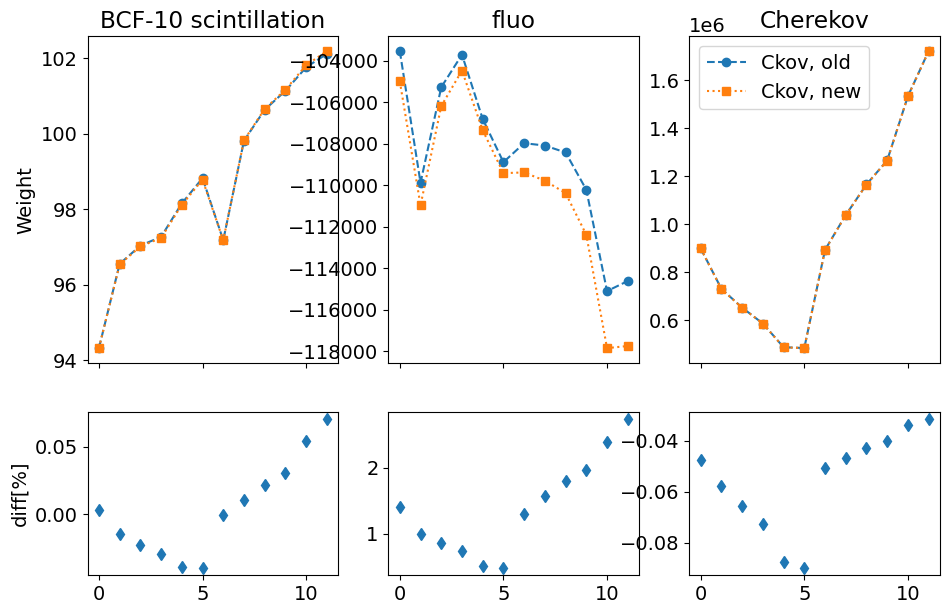

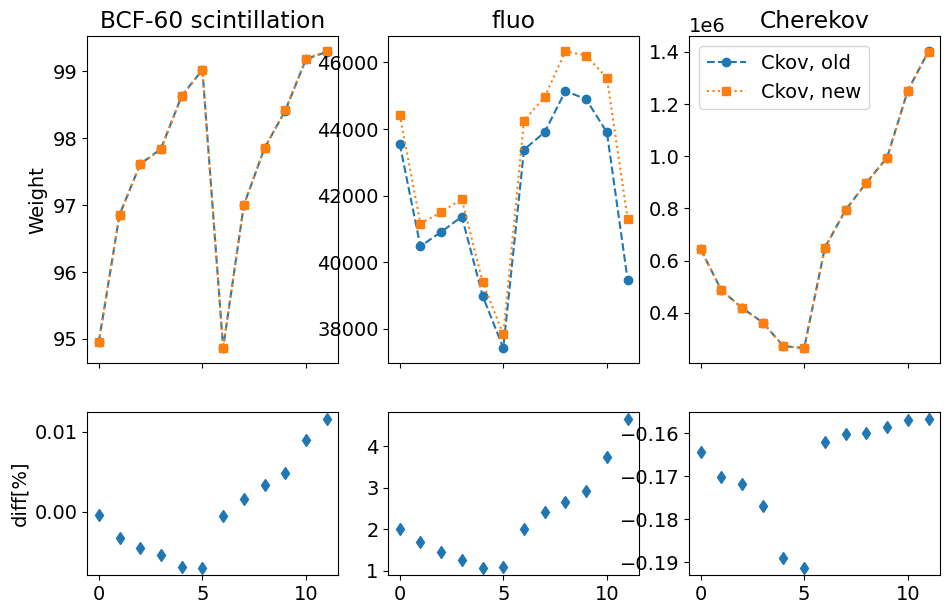

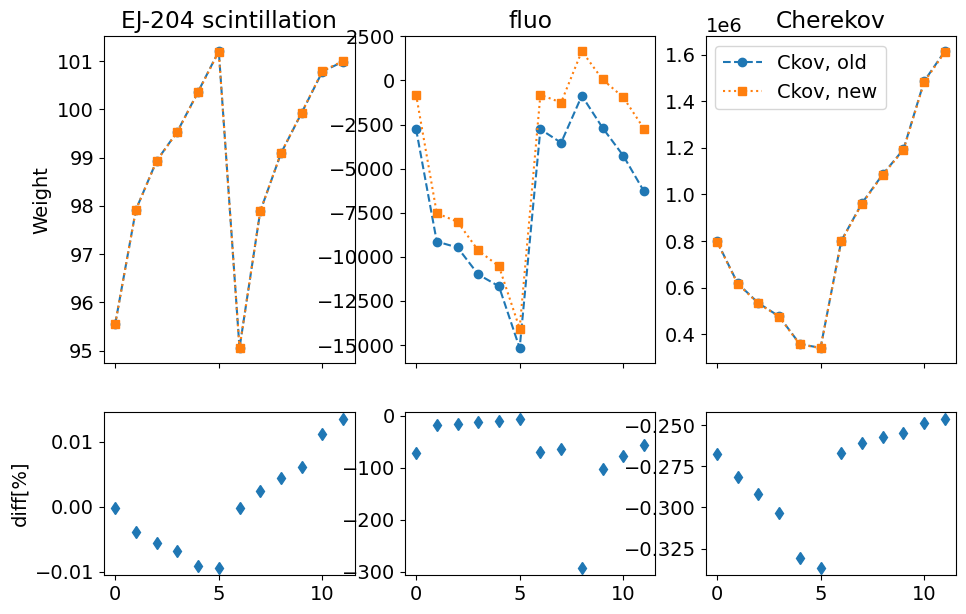

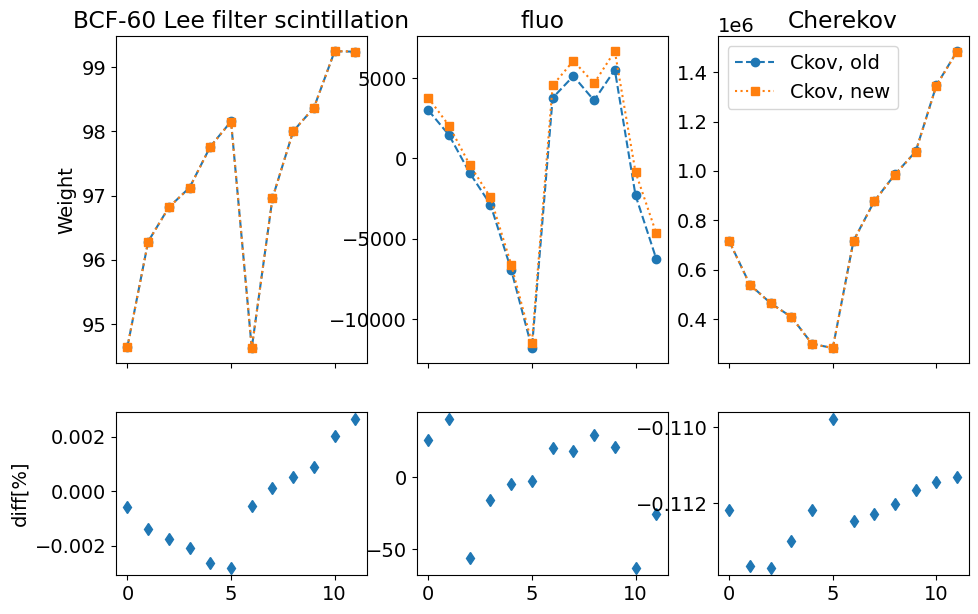

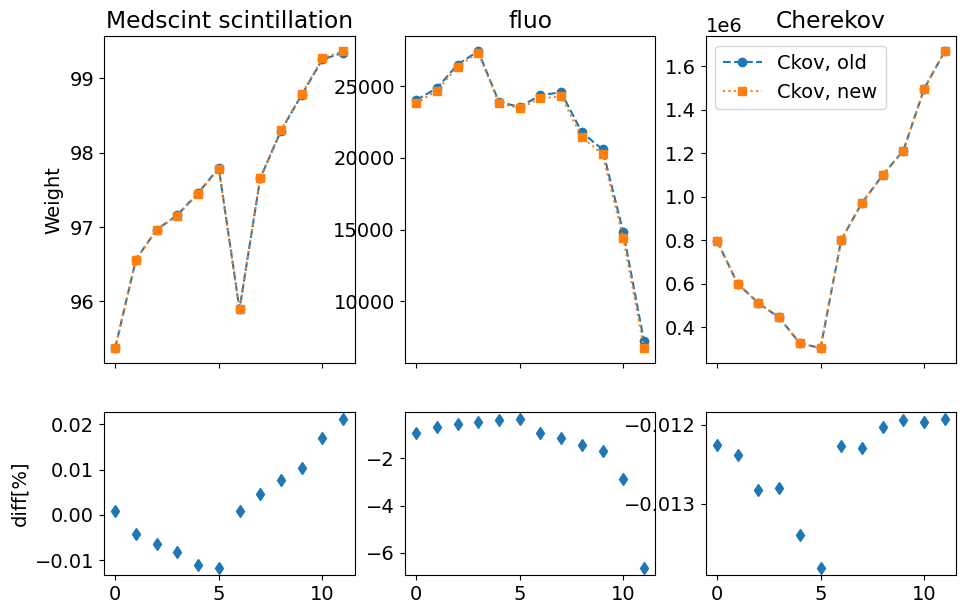

In [20]:
 Mean_dose_old, Mean_fluo_old, Mean_ckov_old, std_dose_old, std_fluo_old, std_ckov_old,  Mean_spectrum_old, Mean_weight_old, std_weight_old = calculate_weigths(cal_scint_old, cal_fluo_old, cal_ckovA_old, cal_ckovB_old, cal_dose_file, Data)
Mean_dose_new, Mean_fluo_new, Mean_ckov_new,  std_dose_new, std_fluo_new,  std_ckov_new,  Mean_spectrum_new, Mean_weight_new, std_weight_new = calculate_weigths(cal_scint_old, cal_fluo_old, cal_ckovA_new, cal_ckovB_new, cal_dose_file, Data)


for s in range(len(scintillators)):
    fig, axes = plt.subplots(nrows=2, ncols=3, gridspec_kw={'height_ratios': [2, 1]},  figsize=(11, 7), sharex=True)
    plt.subplot(231)
    plt.title(scint_label[s] + ' scintillation')
    plt.plot( Mean_dose_old[s], 'o--', label='old')
    plt.plot( Mean_dose_new[s], 's:', label='new')
    plt.ylabel('Weight')
    plt.subplot(234)
    plt.plot( 100*(Mean_dose_new[s]-Mean_dose_old[s])/Mean_dose_old[s], 'd')
    plt.ylabel('diff[%]')
    plt.subplot(232)
    plt.title('fluo')
    plt.plot( Mean_fluo_old[s], 'o--',label='old')
    plt.plot( Mean_fluo_new[s],'s:', label='new')
    plt.subplot(235)
    plt.plot( 100*(Mean_fluo_new[s]-Mean_fluo_old[s])/Mean_fluo_old[s], 'd')
    plt.subplot(233)
    plt.title('Cherekov')
    plt.plot( Mean_ckov_old[s], 'o--', label='Ckov, old')
    plt.plot( Mean_ckov_new[s],'s:', label='Ckov, new')
    plt.legend()
    plt.subplot(236)
    plt.plot( 100*(Mean_ckov_new[s]-Mean_ckov_old[s])/Mean_ckov_old[s], 'd')

    plt.show()


In [21]:
def generate_plots(s, Mean_ckov_new, Mean_ckov_old, scint_label, colors, colors2):

    # Comparison of new weights for each scintillator
    plt.subplot(211)
    plt.title(scint_label[s])
    plt.plot(Mean_ckov_new[s], 'o', color=colors[s+1], label=scint_label[s] + ' ckov new')
    plt.plot(Mean_ckov_old[s], '>', color=colors[s], label=scint_label[s] + ' ckov old')
    plt.axhline(y=0, color='black', linestyle=':')
    plt.legend(loc='best')
    plt.tight_layout()

    # Create a table to compare c and d
    c = Mean_ckov_new[s]
    d = Mean_ckov_old[s]
    bfields_label = ['0', '0.2', '0.35', '0.5', '1', '1.5', '0', '-0.2', '-0.35', '-0.5', '-1', '-1.5']

    # Calculate the relative differences between c and d
    diff = 100*(c - d)/d

    # Round the values to 4 decimal places
    c = np.around(c, 4)
    d = np.around(d, 4)
    diff = np.around(diff, 4)

    # Create a DataFrame with the values and differences
    df = pd.DataFrame({'Magnetic field [T]':bfields_label,  'Ckov A + B new': c, 'Ckov A + B old': d, 'Diff [%]': diff})

    # Define a color map for the table
    cmap = plt.cm.coolwarm

    # Create a table with color-coded values
    fig, ax = plt.subplots()
    ax.axis('off')
    table = ax.table(cellText=df.values, colLabels=df.columns, loc='center', cellLoc='center')

    # Color the cells based on the differences
    for i in range(len(diff)):
        for j in range(len(df.columns)):
            color = cmap((diff[i] + np.abs(diff.min())) / (np.abs(diff).max() + np.abs(diff.min())))
            table.get_celld()[(i+1, j)].set_facecolor(color)
    # Create a color bar
    norm = mpl.colors.Normalize(vmin=diff.min(), vmax=diff.max())
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    fig.colorbar(sm, ax=ax)


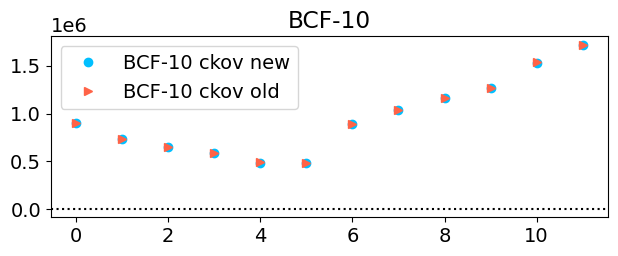

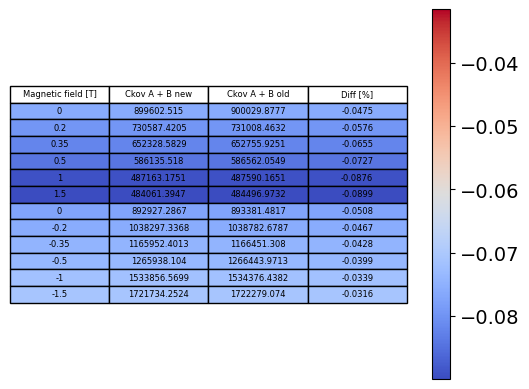

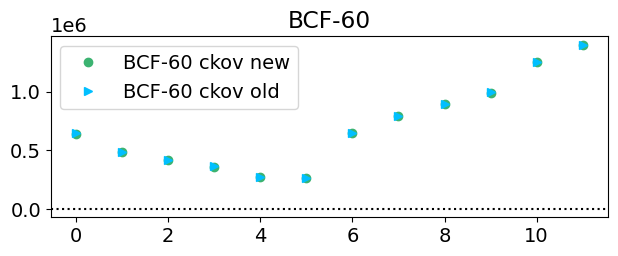

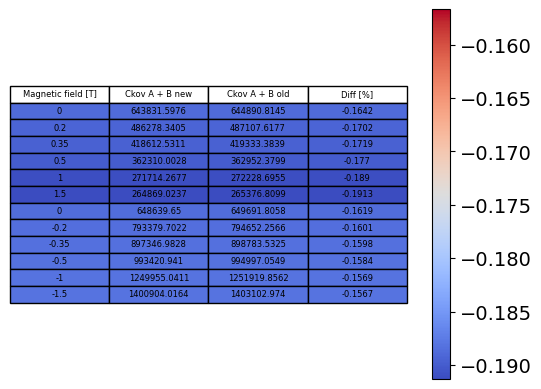

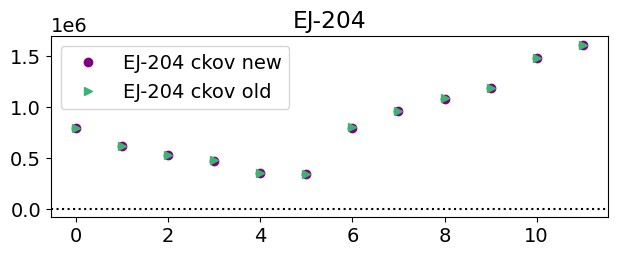

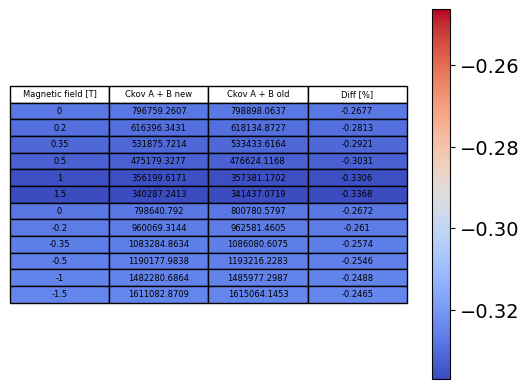

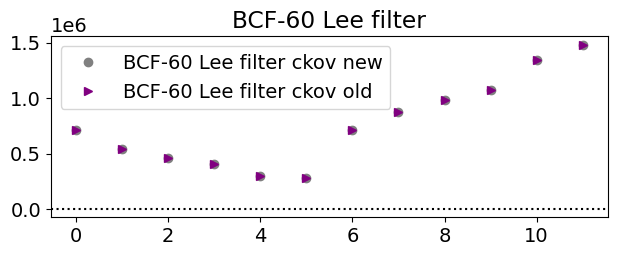

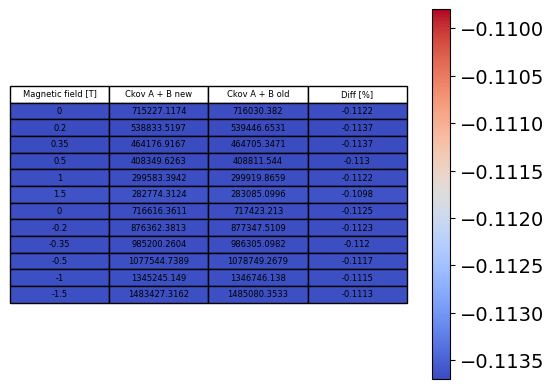

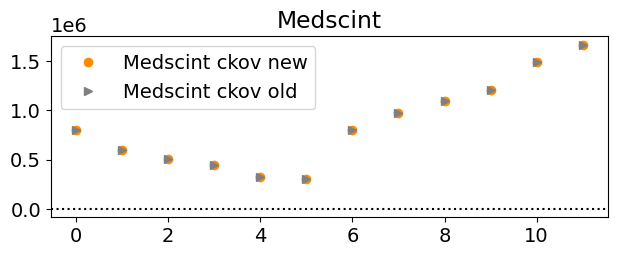

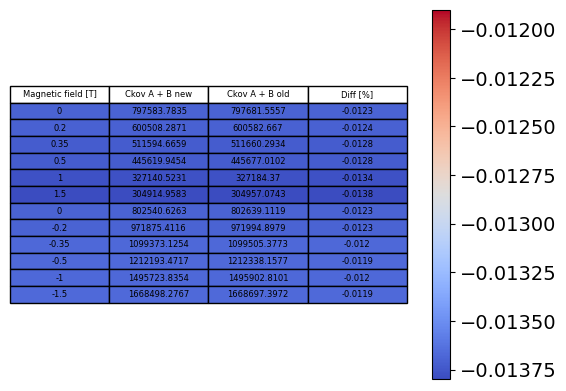

In [22]:
for s in range(len(scintillators)):
    generate_plots(s, Mean_ckov_new, Mean_ckov_old, scint_label, colors, colors2)
    plt.show()

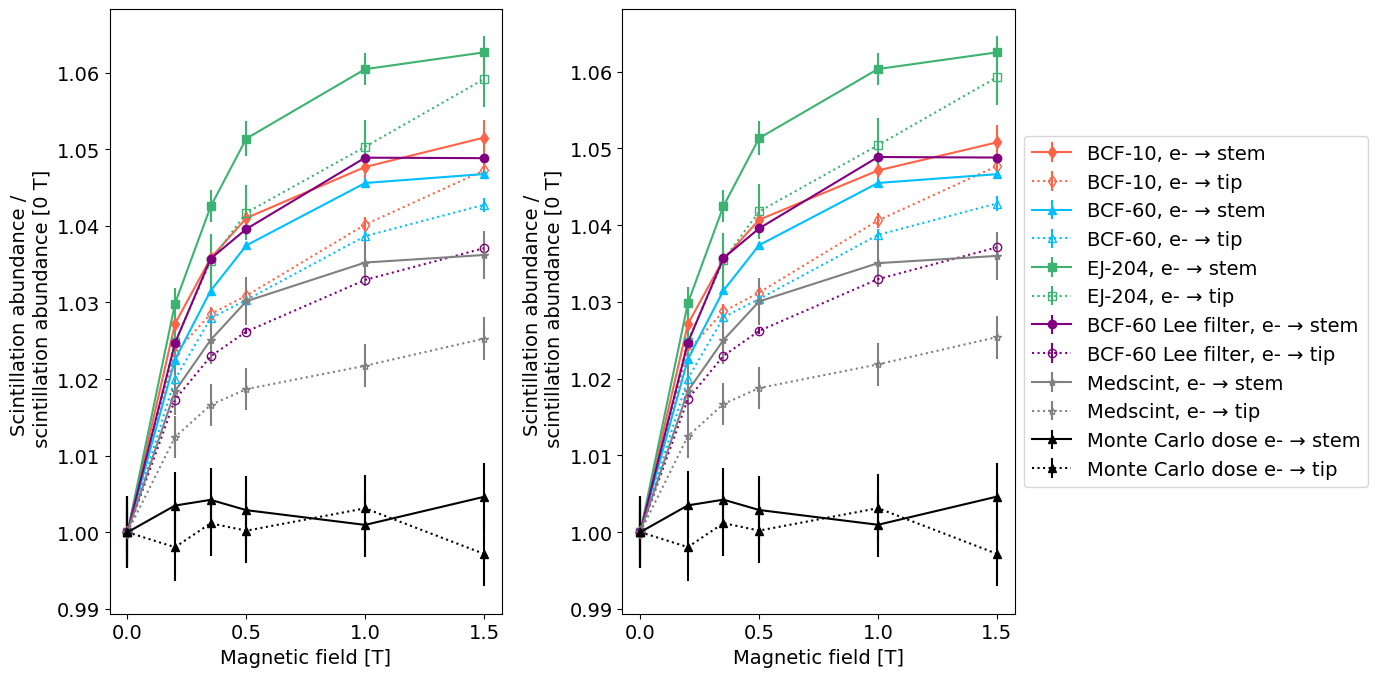

In [23]:
# Plot Scintillation
path ="/Users/yunuen/PycharmProjects/PC_NPLmeasurements/Experimental_analysis/"
#Monte Carlo data
data_mc = np.load(path + 'dose_mc.npz')
bfields_mc = [-1.5, -1, -0.5, -0.35, -0.2, 0, 0.2, 0.35, 0.5, 1, 1.5]
dose_mc = data_mc['dose_mc']
j = bfields_mc.index(0)

# Scintillation
fig = plt.figure(figsize=(14, 7))
plt.rcParams.update({'font.size': 14})
plt.subplot(121)
for s in range(len(scintillators) ):
    plt.errorbar(bfields, Mean_dose_new[s][6:12] / Mean_dose_new[s][6],
                 yerr=np.sqrt((std_dose_new[s][6:12] / Mean_dose_new[s][6:12]) ** 2 + (std_dose_new[s][6] / Mean_dose_new[s][6]) ** 2) *
                      (Mean_dose_new[s][6:12] / Mean_dose_new[s][6]), color=colors[s], fmt=symbol[s], linestyle='-',
                 label=scint_label[s] + ', e- \u2192 stem')
    plt.errorbar(bfields, Mean_dose_new[s][0:6] / Mean_dose_new[s][0],
                 yerr=np.sqrt((std_dose_new[s][0:6] / Mean_dose_new[s][0:6]) ** 2 + (std_dose_new[s][0] / Mean_dose_new[s][0]) ** 2) * (
                      Mean_dose_new[s][0:6] / Mean_dose_new[s][0]), markerfacecolor='none', color=colors[s], fmt=symbol[s], linestyle=':',
                 label=scint_label[s] + ', e- \u2192 tip')
    plt.ylabel('Scintillation abundance / \n scintillation abundance [0 T]')
    plt.xlabel('Magnetic field [T]')
 # Monte Carlo
plt.errorbar(np.abs(bfields_mc[:j + 1]), dose_mc[1, :j + 1, 0] / dose_mc[1, j, 0],
                 yerr=np.sqrt(dose_mc[1, :j + 1, 2] ** 2 + dose_mc[1, j, 2] ** 2), fmt='-^', color='black',
                 label='Monte Carlo dose' + ' e- \u2192 stem')
plt.errorbar(np.abs(bfields_mc[j:]), dose_mc[1, j:, 0] / dose_mc[1, j, 0],
                 yerr=np.sqrt(dose_mc[1, j:, 2] ** 2 + dose_mc[1, j, 2] ** 2), fmt=':^', color='black',
                 label='Monte Carlo dose' + ' e- \u2192 tip')

plt.subplot(122)
for s in range(len(scintillators) ):
    plt.errorbar(bfields, Mean_dose_old[s][6:12] / Mean_dose_old[s][6],
                 yerr=np.sqrt((std_dose_old[s][6:12] / Mean_dose_old[s][6:12]) ** 2 + (std_dose_old[s][6] / Mean_dose_old[s][6]) ** 2) *
                      (Mean_dose_old[s][6:12] / Mean_dose_old[s][6]), color=colors[s], fmt=symbol[s], linestyle='-',
                 label=scint_label[s] + ', e- \u2192 stem')
    plt.errorbar(bfields, Mean_dose_old[s][0:6] / Mean_dose_old[s][0],
                 yerr=np.sqrt((std_dose_old[s][0:6] / Mean_dose_old[s][0:6]) ** 2 + (std_dose_old[s][0] / Mean_dose_old[s][0]) ** 2) * (
                      Mean_dose_old[s][0:6] / Mean_dose_old[s][0]), markerfacecolor='none', color=colors[s], fmt=symbol[s], linestyle=':',
                 label=scint_label[s] + ', e- \u2192 tip')
    plt.ylabel('Scintillation abundance / \n scintillation abundance [0 T]')
    plt.xlabel('Magnetic field [T]')
 # Monte Carlo
plt.errorbar(np.abs(bfields_mc[:j + 1]), dose_mc[1, :j + 1, 0] / dose_mc[1, j, 0],
                 yerr=np.sqrt(dose_mc[1, :j + 1, 2] ** 2 + dose_mc[1, j, 2] ** 2), fmt='-^', color='black',
                 label='Monte Carlo dose' + ' e- \u2192 stem')
plt.errorbar(np.abs(bfields_mc[j:]), dose_mc[1, j:, 0] / dose_mc[1, j, 0],
                 yerr=np.sqrt(dose_mc[1, j:, 2] ** 2 + dose_mc[1, j, 2] ** 2), fmt=':^', color='black',
                 label='Monte Carlo dose' + ' e- \u2192 tip')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

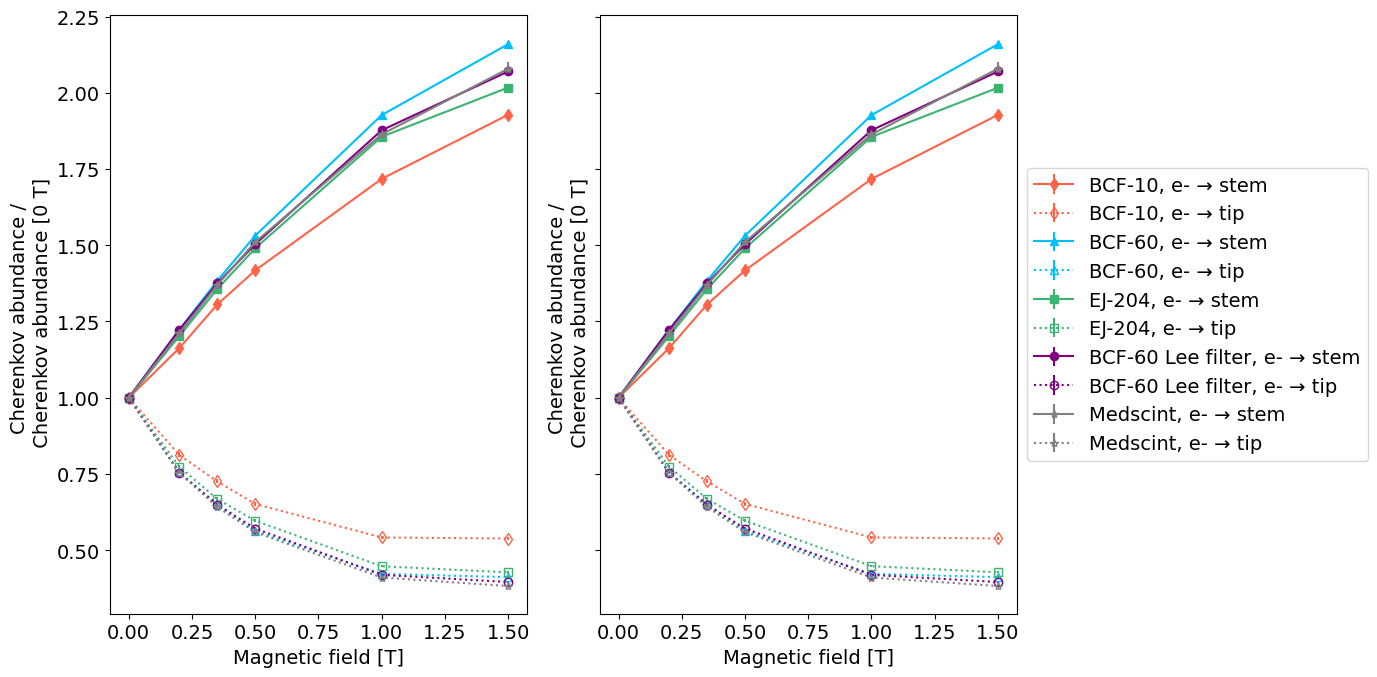

In [24]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 7), sharey=True)

plt.rcParams.update({'font.size': 14})
plt.subplot(121)
for s in range(len(scintillators) ):
    plt.errorbar(bfields, Mean_ckov_new[s][6:12] / Mean_ckov_new[s][6],
                 yerr=np.sqrt((std_ckov_new[s][6:12] / Mean_ckov_new[s][6:12]) ** 2 + (std_ckov_new[s][6] / Mean_ckov_new[s][6]) ** 2) *
                      (Mean_ckov_new[s][6:12] / Mean_ckov_new[s][6]), color=colors[s], fmt=symbol[s], linestyle='-',
                 label=scint_label[s] + ', e- \u2192 stem')
    plt.errorbar(bfields, Mean_ckov_new[s][0:6] / Mean_ckov_new[s][0],
                 yerr=np.sqrt((std_ckov_new[s][0:6] / Mean_ckov_new[s][0:6]) ** 2 + (std_ckov_new[s][0] / Mean_ckov_new[s][0]) ** 2) * (
                      Mean_ckov_new[s][0:6] / Mean_ckov_new[s][0]), markerfacecolor='none', color=colors[s], fmt=symbol[s], linestyle=':',
                 label=scint_label[s] + ', e- \u2192 tip')
    plt.ylabel('Cherenkov abundance / \n Cherenkov abundance [0 T]')
    plt.xlabel('Magnetic field [T]')


plt.subplot(122)
for s in range(len(scintillators) ):
    plt.errorbar(bfields, Mean_ckov_old[s][6:12] / Mean_ckov_old[s][6],
                 yerr=np.sqrt((std_ckov_old[s][6:12] / Mean_ckov_old[s][6:12]) ** 2 + (std_ckov_old[s][6] / Mean_ckov_old[s][6]) ** 2) *
                      (Mean_ckov_old[s][6:12] / Mean_ckov_old[s][6]), color=colors[s], fmt=symbol[s], linestyle='-',
                 label=scint_label[s] + ', e- \u2192 stem')
    plt.errorbar(bfields, Mean_ckov_old[s][0:6] / Mean_ckov_old[s][0],
                 yerr=np.sqrt((std_ckov_old[s][0:6] / Mean_ckov_old[s][0:6]) ** 2 + (std_ckov_old[s][0] / Mean_ckov_old[s][0]) ** 2) * (
                      Mean_ckov_old[s][0:6] / Mean_ckov_old[s][0]), markerfacecolor='none', color=colors[s], fmt=symbol[s], linestyle=':',
                 label=scint_label[s] + ', e- \u2192 tip')
    plt.ylabel('Cherenkov abundance / \n Cherenkov abundance [0 T]')
    plt.xlabel('Magnetic field [T]')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

PCA analysis for new and original calibration

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


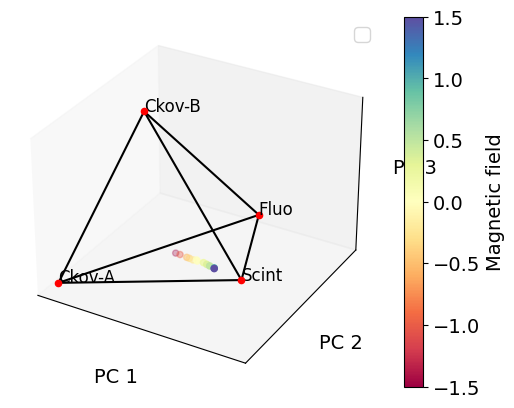

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


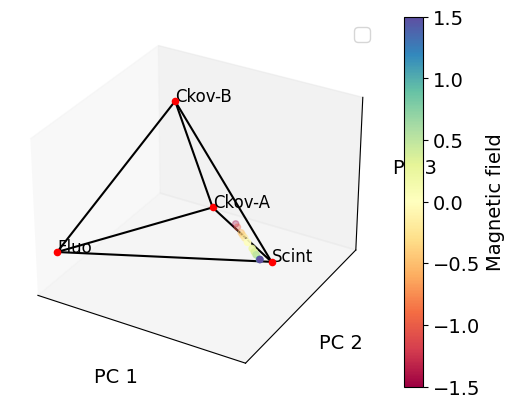

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


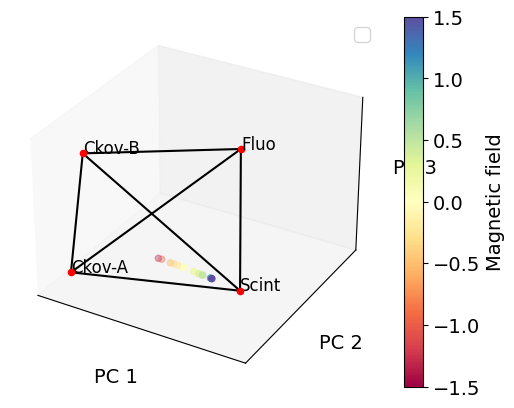

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


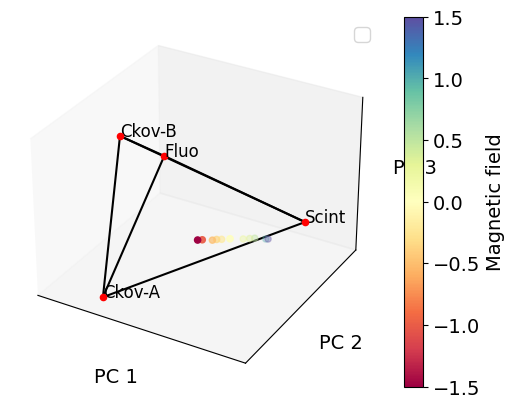

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


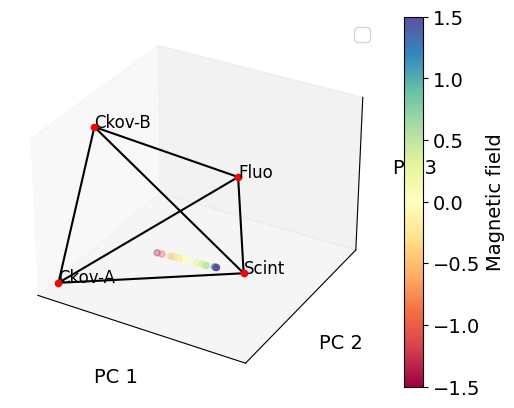

In [26]:
cal_spectra=np.zeros([5, 4, 137])
dose_spectra_norm=np.zeros([12, 137])

for s in range(len(scintillators)):
    # Normalization of spectra
    cal_spectra[s, 0, :] = cal_scint_old[s]/sum(cal_scint_old[s])
    cal_spectra[s, 1, :] = cal_ckovA_new[s]/sum(cal_ckovA_new[s])
    cal_spectra[s, 2, :] = cal_ckovB_new[s]/sum(cal_ckovB_new[s])
    cal_spectra[s, 3, :] = cal_fluo_old[s] / sum(cal_fluo_old[s])
    norm_calib_spectra=cal_spectra[s]

    # Mean spectrum has a shape 5 x 12 x 137
    # Changing the order of the bfields so i can from -1.5 T to 1.5 T
    for b in range(6):
        dose_spectra_norm[b] = Mean_spectrum_new[s, 11-b]/sum(Mean_spectrum_new[s, 11-b])
        dose_spectra_norm[b+6] = Mean_spectrum_new[s, b] / sum(Mean_spectrum_new[s, b])



    [pc_spectra,c_dataset] = make_PCA(norm_calib_spectra,dose_spectra_norm)
    plot_PCA(pc_spectra,c_dataset)
    plt.legend()
    plt.show()